In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, train_test_split, learning_curve,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
rnd_state = 0

In [2]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
cursor.execute('SET search_path to {}'.format(schema_name))

In [3]:
# Load in the query from file
query='SELECT * FROM admissions'
ad = pd.read_sql_query(query, connect)

In [4]:
ad.shape

(58976, 19)

In [5]:
ad.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [6]:
# Load in the query from file
query='SELECT * FROM APSIII'
aps = pd.read_sql_query(query, connect)

In [7]:
aps.shape

(61532, 21)

In [8]:
aps.head()

,subject_id,hadm_id,icustay_id,apsiii,apsiii_prob,hr_score,meanbp_score,temp_score,resprate_score,pao2_aado2_score,hematocrit_score,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score
0,55973,152234,200001,63,0.188678,7.0,7.0,0.0,6.0,0.0,3.0,5.0,7.0,15.0,12.0,0.0,NaN,0.0,0.0,1.0,0.0
1,27513,163557,200003,48,0.102705,7.0,10.0,0.0,9.0,0.0,3.0,5.0,0.0,0.0,7.0,0.0,0.0,6.0,0.0,1.0,0.0
2,10950,189514,200006,23,0.033927,0.0,7.0,0.0,6.0,NaN,3.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,3.0,NaN,0.0
3,20707,129310,200007,33,0.053332,1.0,15.0,0.0,6.0,NaN,3.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,3.0,NaN,0.0
4,29904,129607,200009,26,0.038894,1.0,7.0,8.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,0.0,3.0,0.0


In [12]:
!pygmentize /Users/maxim/Documents/ml_nanodegree/capstone/mortality_predictor_mimic/queries/apsiii_raw.sql

with pa as
(
  select bg.icustay_id, bg.charttime
  , PO2 as PaO2
  , ROW_NUMBER() over (partition by bg.ICUSTAY_ID ORDER BY bg.PO2 DESC) as rn
  from bloodgasfirstdayarterial bg
  left join ventdurations vd
    on bg.icustay_id = vd.icustay_id
    and bg.charttime >= vd.starttime
    and bg.charttime <= vd.endtime
  WHERE vd.icustay_id is null -- is *not* ventilated
  -- and fio2 < 50, or if no fio2, assume room air
  AND coalesce(FIO2, fio2_chartevents, 21) < 50
  AND bg.PO2 IS NOT NULL
)
, aa as
(
  -- join blood gas to ventilation durations to determine if patient was vent
  -- also join to cpap table for the same purpose
  select bg.icustay_id, bg.charttime
  , bg.AADO2
  , ROW_NUMBER() over (partition by bg.ICUSTAY_ID ORDER BY bg.AADO2 DESC) as rn
  -- row number indicating the highest AaDO2
  from bloodgasfirstdayarterial bg
  INNER JOIN ventdurations vd
    on bg.icustay_id = vd.icustay_id
    and bg.charttime >= vd.starttime
    and bg.charttime <= vd.endtime
  WHERE vd.icusta

In [10]:
f = os.path.join('/Users/maxim/Documents/ml_nanodegree/capstone/mortality_predictor_mimic/queries/apsiii_raw.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
aps_raw = pd.read_sql_query(query, connect)

In [11]:
aps_raw.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,albumin_min,albumin_max,bilirubin_min,bilirubin_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,pao2,aado2
0,9514,127229,200014,58.0,71.843750,91.0,52.0,86.268525,171.000000,34.500000,35.856444,37.000000,9.0,14.378378,33.0,29.8,36.3,14.3,14.7,0.6,0.6,24.0,24.0,142.0,144.0,2.2,2.8,0.3,0.3,101.0,114.0,664.0,4.0,4.0,6.0,95.0,NaN
1,76603,179633,200024,101.0,110.571429,123.0,66.0,81.000000,100.000000,34.000000,34.300000,34.600000,18.0,20.166667,21.0,26.0,33.6,12.4,12.4,2.2,2.2,50.0,50.0,145.0,145.0,NaN,NaN,NaN,NaN,50.0,81.0,NaN,1.0,0.0,1.0,NaN,NaN
2,25225,147080,200055,72.0,86.875000,101.0,53.0,67.714286,85.000000,35.666667,36.064815,36.277778,12.0,17.833333,30.0,34.5,36.3,5.7,6.3,7.4,8.9,29.0,40.0,137.0,140.0,3.5,3.5,0.3,0.3,85.0,116.0,NaN,3.0,5.0,6.0,80.0,NaN
3,17145,105119,200068,67.0,83.625000,112.0,56.0,70.623201,84.666702,34.722222,36.904763,38.833334,20.0,22.666667,24.0,27.5,30.0,14.2,14.2,3.2,3.7,58.0,65.0,134.0,136.0,2.3,2.3,0.3,0.3,105.0,187.0,1280.0,4.0,5.0,4.0,86.0,NaN
4,52619,175374,200099,68.0,82.656250,93.0,50.0,71.500000,102.000000,36.000000,36.166667,36.444444,9.0,13.875000,22.0,28.8,34.9,8.9,9.2,1.1,1.2,20.0,20.0,138.0,140.0,NaN,NaN,NaN,NaN,84.0,258.0,955.0,3.0,5.0,6.0,88.0,NaN


In [13]:
aps_raw.shape

(61532, 37)

In [15]:
aps_ad = aps_raw.merge(ad,how='left',on=['hadm_id','subject_id'])
aps_ad = aps_ad.fillna(np.nan)

In [16]:
aps_ad.shape

(61532, 54)

In [17]:
features = ['heartrate_min', 'heartrate_mean', 'heartrate_max',\
            'meanbp_min', 'meanbp_mean', 'meanbp_max',\
            'tempc_min', 'tempc_mean', 'tempc_max',\
            'resprate_min', 'resprate_mean', 'resprate_max',\
            'hematocrit_min', 'hematocrit_max', 'wbc_min', 'wbc_max',\
            'creatinine_min', 'creatinine_max', 'bun_min', 'bun_max',\
            'sodium_min', 'sodium_max', 'glucose_min', 'glucose_max', 'urineoutput',\
            'gcseyes', 'gcsverbal', 'gcsmotor','hospital_expire_flag']
aps_ad = aps_ad[features]
aps_ad.loc[aps_ad.creatinine_min > 20, 'creatinine_min'] = 20
aps_ad.loc[aps_ad.creatinine_max > 20, 'creatinine_max'] = 20
aps_ad.loc[aps_ad.glucose_min > 400, 'glucose_min'] = 400
aps_ad.loc[aps_ad.glucose_max > 1000, 'glucose_max'] = 1000
aps_ad.loc[aps_ad.urineoutput < 0, 'urineoutput'] = np.nan
aps_ad.loc[aps_ad.urineoutput > 10000, 'urineoutput'] = 10000
aps_ad.loc[aps_ad.tempc_min < 32, 'tempc_min'] = np.nan
aps_ad.loc[aps_ad.tempc_min > 42, 'tempc_min'] = 42
aps_ad.loc[aps_ad.tempc_max < 32, 'tempc_max'] = np.nan
aps_ad.loc[aps_ad.tempc_max > 42, 'tempc_max'] = 42
aps_ad.loc[aps_ad.tempc_mean < 32, 'tempc_mean'] = np.nan
aps_ad.loc[aps_ad.tempc_mean > 42, 'tempc_mean'] = 42
aps_ad.loc[aps_ad.sodium_min < 100, 'sodium_min'] = 100
aps_ad.loc[aps_ad.wbc_min > 50, 'wbc_min'] = 50
aps_ad.loc[aps_ad.wbc_max > 50, 'wbc_max'] = 50

In [18]:
aps_ad.shape

(61532, 29)

In [19]:
aps_ad.describe()

,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,hospital_expire_flag
count,59048.000000,59048.000000,59048.000000,52288.000000,52288.000000,52288.000000,51289.000000,51374.000000,51376.000000,52229.000000,52229.000000,52229.000000,59540.000000,59540.000000,59170.000000,59170.000000,52900.000000,52900.000000,52890.000000,52890.000000,54804.000000,54804.00000,54452.000000,54452.000000,53189.000000,51988.000000,51795.000000,51734.000000,61532.000000
mean,77.499570,91.704638,109.723335,58.310360,77.906124,104.690279,36.107098,36.817985,37.471464,12.364435,18.853713,27.275403,32.036125,37.209335,10.903774,13.662593,1.325144,1.572985,24.039024,28.386141,136.668710,140.08174,103.365584,187.348123,1802.785696,3.123836,3.189439,5.168960,0.107408
std,23.394808,23.126838,26.585284,13.810195,11.393066,26.097304,0.736353,0.630895,0.796598,3.767069,4.042130,6.592321,9.063132,7.534391,5.984465,7.077147,1.413009,1.688409,19.966592,22.823167,4.888231,4.64438,33.757871,101.893659,1329.219672,1.110481,2.167278,1.627132,0.309633
min,0.158000,30.000000,30.000000,0.200000,17.428571,23.000000,32.000000,32.000000,32.000000,0.200000,7.000000,8.000000,4.000000,11.000000,0.100000,0.100000,0.100000,0.100000,1.000000,1.000000,100.000000,97.00000,0.106000,9.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,62.000000,75.892857,91.000000,51.000000,70.130435,90.000000,35.666667,36.433333,36.944444,10.000000,16.030303,23.000000,25.900000,31.900000,7.000000,9.000000,0.700000,0.800000,12.000000,14.000000,134.000000,138.00000,83.000000,129.000000,876.000000,3.000000,1.000000,5.000000,0.000000
50%,72.000000,86.974521,105.000000,58.000000,76.524729,100.000000,36.111111,36.790123,37.388891,12.000000,18.190476,26.000000,30.500000,36.000000,9.740000,12.300000,0.900000,1.000000,17.000000,21.000000,137.000000,140.00000,99.000000,164.000000,1582.000000,4.000000,5.000000,6.000000,0.000000
75%,86.000000,101.636364,124.000000,66.000000,84.515152,113.000000,36.555557,37.187500,37.944444,14.000000,21.034483,30.000000,36.300000,41.200000,13.400000,16.800000,1.300000,1.600000,29.000000,34.000000,140.000000,142.00000,119.000000,212.000000,2470.000000,4.000000,5.000000,6.000000,0.000000
max,218.000000,244.800000,286.000000,125.000000,153.838710,299.000000,40.833333,40.833333,42.000000,47.000000,47.000000,69.000000,68.700000,74.400000,50.000000,50.000000,20.000000,20.000000,254.000000,272.000000,178.000000,182.00000,400.000000,1000.000000,10000.000000,4.000000,5.000000,6.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a267154e0>,
      dtype=object)

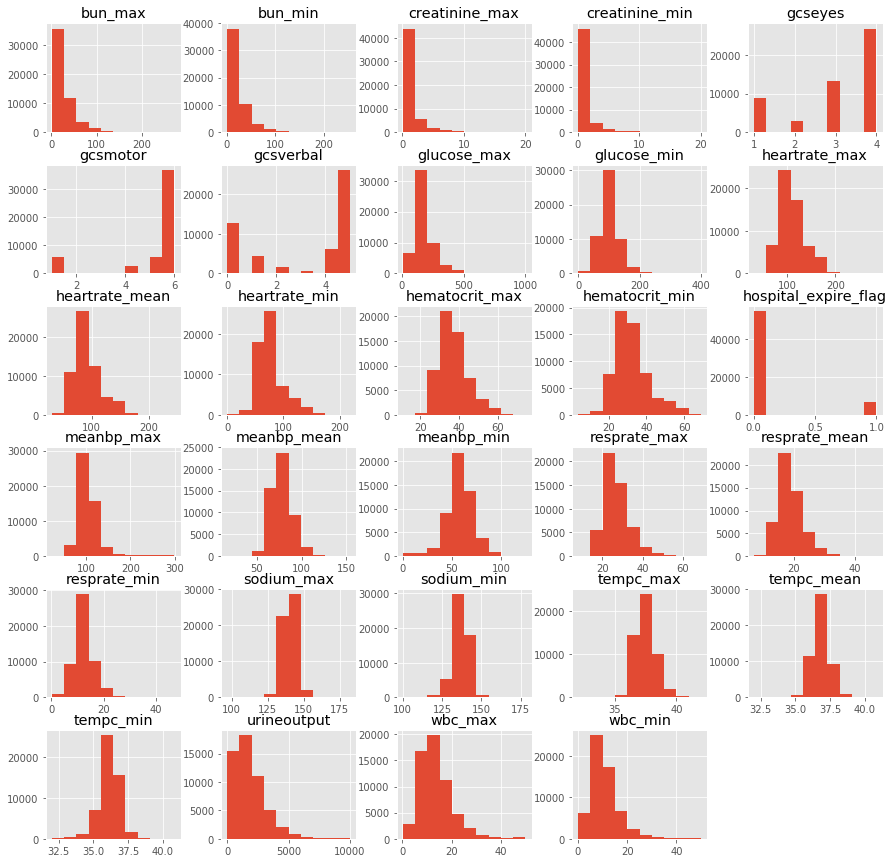

In [20]:
aps_ad.hist(figsize=(15,15))

In [23]:
num_features = ['heartrate_min', 'heartrate_mean', 'heartrate_max',\
            'meanbp_min', 'meanbp_mean', 'meanbp_max',\
            'tempc_min', 'tempc_mean', 'tempc_max',\
            'resprate_min', 'resprate_mean', 'resprate_max',\
            'hematocrit_min', 'hematocrit_max', 'wbc_min', 'wbc_max',\
            'creatinine_min', 'creatinine_max', 'bun_min', 'bun_max',\
            'sodium_min', 'sodium_max', 'glucose_min', 'glucose_max', 'urineoutput',\
            'gcseyes', 'gcsverbal', 'gcsmotor']
X = aps_ad[num_features]
y = aps_ad.hospital_expire_flag
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    shuffle=True, stratify=y, random_state=rnd_state)


In [24]:
print('Shape of training set: {}'.format(X_train_orig.shape))
print('Shape of test set: {}'.format(X_test_orig.shape))
print('Number of positives in training set: {}'.format(y_train.sum()))
print('Number of positives in test set: {}'.format(y_test.sum()))

Shape of training set: (49225, 28)
Shape of test set: (12307, 28)
Number of positives in training set: 5287
Number of positives in test set: 1322


In [25]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
scale = ('scale', MinMaxScaler())
num_transformer = Pipeline([num_impute, scale])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features)])

X_train = preprocessor.fit_transform(X_train_orig)
X_test = preprocessor.transform(X_test_orig)

In [30]:
lr = LogisticRegression(random_state=rnd_state,solver='lbfgs',max_iter=1000,class_weight='balanced',C=1.0,tol=0.0001)

lr.fit(X_train, y_train)

predictions = lr.predict(X_test)

F1 = f1_score(y_test, predictions)
auroc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.40 auroc: 0.84 precision: 0.28 recall: 0.74


In [27]:
apsiii = aps.merge(ad,how='left',on=['hadm_id','subject_id'])

In [28]:
aps_predictions = apsiii.apsiii_prob.values
aps_binary_predictions = apsiii.apsiii_prob.round().values
y_full = apsiii.hospital_expire_flag.values
F1 = f1_score(y_full, aps_binary_predictions)
auroc = roc_auc_score(y_full, aps_predictions)
precision = precision_score(y_full, aps_binary_predictions)
recall = recall_score(y_full, aps_binary_predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.23 auroc: 0.80 precision: 0.65 recall: 0.14


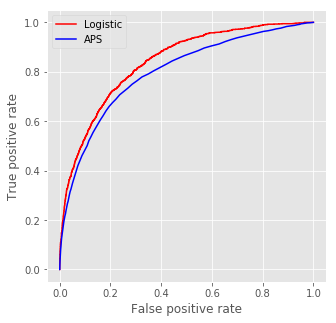

In [31]:
f, axs = plt.subplots(1,1,figsize=(5,5))

x,y,_ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.plot(x,y,label='Logistic',color='red')
x,y,_ = roc_curve(y_full, aps_predictions)
plt.plot(x,y,label='APS',color='blue')
plt.legend(loc='best')
axs.set_xlabel('False positive rate')
axs.set_ylabel('True positive rate')

plt.savefig('logisic_aps.pdf')

# Neural network

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [33]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [34]:
from torch.utils import data
class Dataset(data.Dataset):
    
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'

        X = self.X[index]
        y = self.y[index]

        return X, y

In [35]:
train_idx, valid_idx= train_test_split(np.arange(len(y_train.values)),test_size=0.2,shuffle=True,stratify=y_train.values)

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(Dataset(X_train,y_train.values), batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(Dataset(X_train,y_train.values), batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(Dataset(X_test,y_test.values), batch_size=batch_size, 
    num_workers=num_workers)

In [36]:
class ThreeLayersNet(nn.Module):
    def __init__(self,hidden):
        super(ThreeLayersNet, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(28, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.hidden)
        self.fc3 = nn.Linear(self.hidden, self.hidden)
        self.fc4 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return x

class TwoLayersNet(nn.Module):
    def __init__(self,hidden):
        super(TwoLayersNet, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(28, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.hidden)
        self.fc3 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

class OneLayerNet(nn.Module):
    def __init__(self,hidden=6):
        super(OneLayerNet, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(28, self.hidden)
        self.fc2 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [37]:
def train_per_hidden(n_epochs, hidden,Net):
    # initialize the NN
    model = Net(hidden=hidden)
    criterion = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_model = None
    valid_loss_min = np.Inf # set initial "min" to infinity
    conv ={'train':[],'valid':[]}
    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        # train the model #
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            target = target.view(-1,1)
            weight=compute_sample_weight(class_weight='balanced', y=target)
            weight=torch.Tensor(weight)
            weight=weight.view(-1,1)
            criterion.weight = weight
            loss = criterion(output.float(), target.float())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()#*data.size(0)

        # validate the model #
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            target = target.view(-1,1)
            weight=compute_sample_weight(class_weight='balanced', y=target)
            weight=torch.Tensor(weight)
            weight=weight.view(-1,1)
            criterion.weight = weight
            loss = criterion(output.float(), target.float())
            # update running validation loss 
            valid_loss += loss.item()#*data.size(0)

        #print('data size:',data.size(0))
        #print('len train loader:',len(train_loader.dataset))
        #print('len valid loader:',len(valid_loader.dataset))
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            valid_loss
            ))
        conv['train'].append(train_loss)
        conv['valid'].append(valid_loss)
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
        #    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        #    valid_loss_min,
        #    valid_loss))
        #    torch.save(model.state_dict(), 'model.pt')
        #    valid_loss_min = valid_loss
            best_model = model
    return conv, best_model

In [264]:
# number of epochs to train the model
n_epochs = 85
hidden = [6, 12, 24, 48, 96, 124]
res = {'conv':[],'model':[]}
for h in hidden:
    print('Hidden=',h)
    conv,model = train_per_hidden(n_epochs, h,OneLayerNet)   
    res['conv'].append(conv)
    res['model'].append(model)


Hidden= 6
Epoch: 1 	Training Loss: 0.605878 	Validation Loss: 0.549598
Epoch: 2 	Training Loss: 0.553668 	Validation Loss: 0.530354
Epoch: 3 	Training Loss: 0.534943 	Validation Loss: 0.528785
Epoch: 4 	Training Loss: 0.526650 	Validation Loss: 0.513660
Epoch: 5 	Training Loss: 0.519469 	Validation Loss: 0.501490
Epoch: 6 	Training Loss: 0.518584 	Validation Loss: 0.501408
Epoch: 7 	Training Loss: 0.519405 	Validation Loss: 0.500432
Epoch: 8 	Training Loss: 0.513515 	Validation Loss: 0.504283
Epoch: 9 	Training Loss: 0.511031 	Validation Loss: 0.501855
Epoch: 10 	Training Loss: 0.511222 	Validation Loss: 0.501437
Epoch: 11 	Training Loss: 0.509335 	Validation Loss: 0.512203
Epoch: 12 	Training Loss: 0.509654 	Validation Loss: 0.502376
Epoch: 13 	Training Loss: 0.508343 	Validation Loss: 0.491473
Epoch: 14 	Training Loss: 0.507432 	Validation Loss: 0.496404
Epoch: 15 	Training Loss: 0.506470 	Validation Loss: 0.495613
Epoch: 16 	Training Loss: 0.505923 	Validation Loss: 0.489609
Epoch: 

Epoch: 49 	Training Loss: 0.477088 	Validation Loss: 0.467894
Epoch: 50 	Training Loss: 0.479391 	Validation Loss: 0.478185
Epoch: 51 	Training Loss: 0.481791 	Validation Loss: 0.463990
Epoch: 52 	Training Loss: 0.480626 	Validation Loss: 0.462325
Epoch: 53 	Training Loss: 0.480713 	Validation Loss: 0.455725
Epoch: 54 	Training Loss: 0.476156 	Validation Loss: 0.467677
Epoch: 55 	Training Loss: 0.473209 	Validation Loss: 0.459244
Epoch: 56 	Training Loss: 0.477854 	Validation Loss: 0.462411
Epoch: 57 	Training Loss: 0.476697 	Validation Loss: 0.461232
Epoch: 58 	Training Loss: 0.474972 	Validation Loss: 0.458162
Epoch: 59 	Training Loss: 0.474781 	Validation Loss: 0.464329
Epoch: 60 	Training Loss: 0.479616 	Validation Loss: 0.463435
Epoch: 61 	Training Loss: 0.475368 	Validation Loss: 0.463246
Epoch: 62 	Training Loss: 0.473144 	Validation Loss: 0.463342
Epoch: 63 	Training Loss: 0.472376 	Validation Loss: 0.467055
Epoch: 64 	Training Loss: 0.475349 	Validation Loss: 0.461641
Epoch: 6

Epoch: 12 	Training Loss: 0.482184 	Validation Loss: 0.475619
Epoch: 13 	Training Loss: 0.477751 	Validation Loss: 0.478489
Epoch: 14 	Training Loss: 0.478411 	Validation Loss: 0.476749
Epoch: 15 	Training Loss: 0.478850 	Validation Loss: 0.481201
Epoch: 16 	Training Loss: 0.474955 	Validation Loss: 0.476248
Epoch: 17 	Training Loss: 0.469999 	Validation Loss: 0.467956
Epoch: 18 	Training Loss: 0.472529 	Validation Loss: 0.470682
Epoch: 19 	Training Loss: 0.473612 	Validation Loss: 0.468972
Epoch: 20 	Training Loss: 0.474820 	Validation Loss: 0.469174
Epoch: 21 	Training Loss: 0.471028 	Validation Loss: 0.464395
Epoch: 22 	Training Loss: 0.469055 	Validation Loss: 0.473388
Epoch: 23 	Training Loss: 0.468677 	Validation Loss: 0.474271
Epoch: 24 	Training Loss: 0.467976 	Validation Loss: 0.466873
Epoch: 25 	Training Loss: 0.464909 	Validation Loss: 0.461878
Epoch: 26 	Training Loss: 0.468240 	Validation Loss: 0.465600
Epoch: 27 	Training Loss: 0.463690 	Validation Loss: 0.465596
Epoch: 2

Epoch: 60 	Training Loss: 0.439542 	Validation Loss: 0.442791
Epoch: 61 	Training Loss: 0.441580 	Validation Loss: 0.444757
Epoch: 62 	Training Loss: 0.438125 	Validation Loss: 0.446113
Epoch: 63 	Training Loss: 0.441959 	Validation Loss: 0.440468
Epoch: 64 	Training Loss: 0.438182 	Validation Loss: 0.439983
Epoch: 65 	Training Loss: 0.435944 	Validation Loss: 0.442072
Epoch: 66 	Training Loss: 0.439702 	Validation Loss: 0.453330
Epoch: 67 	Training Loss: 0.437871 	Validation Loss: 0.439414
Epoch: 68 	Training Loss: 0.438262 	Validation Loss: 0.439625
Epoch: 69 	Training Loss: 0.437003 	Validation Loss: 0.443263
Epoch: 70 	Training Loss: 0.435452 	Validation Loss: 0.445252
Epoch: 71 	Training Loss: 0.436268 	Validation Loss: 0.443817
Epoch: 72 	Training Loss: 0.445434 	Validation Loss: 0.438390
Epoch: 73 	Training Loss: 0.439085 	Validation Loss: 0.441731
Epoch: 74 	Training Loss: 0.438849 	Validation Loss: 0.441117
Epoch: 75 	Training Loss: 0.437206 	Validation Loss: 0.444861
Epoch: 7

Epoch: 23 	Training Loss: 0.448190 	Validation Loss: 0.449286
Epoch: 24 	Training Loss: 0.446576 	Validation Loss: 0.448246
Epoch: 25 	Training Loss: 0.449229 	Validation Loss: 0.465807
Epoch: 26 	Training Loss: 0.443883 	Validation Loss: 0.457897
Epoch: 27 	Training Loss: 0.447837 	Validation Loss: 0.452526
Epoch: 28 	Training Loss: 0.447849 	Validation Loss: 0.460514
Epoch: 29 	Training Loss: 0.450272 	Validation Loss: 0.450306
Epoch: 30 	Training Loss: 0.447005 	Validation Loss: 0.442308
Epoch: 31 	Training Loss: 0.441582 	Validation Loss: 0.450282
Epoch: 32 	Training Loss: 0.444185 	Validation Loss: 0.439513
Epoch: 33 	Training Loss: 0.447403 	Validation Loss: 0.453718
Epoch: 34 	Training Loss: 0.445156 	Validation Loss: 0.450217
Epoch: 35 	Training Loss: 0.447575 	Validation Loss: 0.437448
Epoch: 36 	Training Loss: 0.444253 	Validation Loss: 0.458020
Epoch: 37 	Training Loss: 0.440320 	Validation Loss: 0.456841
Epoch: 38 	Training Loss: 0.446486 	Validation Loss: 0.449149
Epoch: 3

Epoch: 71 	Training Loss: 0.431319 	Validation Loss: 0.441024
Epoch: 72 	Training Loss: 0.428912 	Validation Loss: 0.438572
Epoch: 73 	Training Loss: 0.435791 	Validation Loss: 0.447416
Epoch: 74 	Training Loss: 0.434691 	Validation Loss: 0.440179
Epoch: 75 	Training Loss: 0.428836 	Validation Loss: 0.447032
Epoch: 76 	Training Loss: 0.427718 	Validation Loss: 0.436361
Epoch: 77 	Training Loss: 0.425923 	Validation Loss: 0.451356
Epoch: 78 	Training Loss: 0.429173 	Validation Loss: 0.456023
Epoch: 79 	Training Loss: 0.431604 	Validation Loss: 0.455673
Epoch: 80 	Training Loss: 0.427171 	Validation Loss: 0.449853
Epoch: 81 	Training Loss: 0.430078 	Validation Loss: 0.436278
Epoch: 82 	Training Loss: 0.425597 	Validation Loss: 0.476160
Epoch: 83 	Training Loss: 0.425054 	Validation Loss: 0.463743
Epoch: 84 	Training Loss: 0.431065 	Validation Loss: 0.450071
Epoch: 85 	Training Loss: 0.423977 	Validation Loss: 0.435952


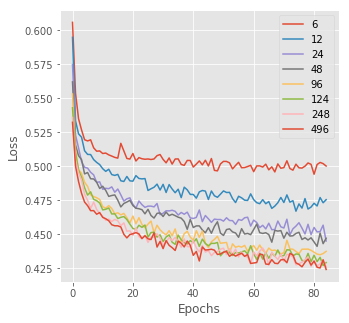

In [265]:
f, axs = plt.subplots(1,1,figsize=(5,5))

for h,conv in zip(hidden,res['conv']):
    plt.plot(conv['train'],label=h)
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.savefig('hidden_aps.pdf')

In [266]:
#model.eval() # prep model for evaluation
def get_predictions(model):
    test_loss = 0.0
    predictions = []
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the loss
        target = target.view(-1,1)
        weight=compute_sample_weight(class_weight='balanced', y=target)
        weight=torch.Tensor(weight)
        weight=weight.view(-1,1)
        criterion.weight = weight
        loss = criterion(output.float(), target.float())
        # update test loss 
        test_loss += loss.item()#*data.size(0)
        predictions += output.view(1,-1).tolist()[0]
    return predictions

In [267]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in res['model']:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.45 auroc: 0.85 precision: 0.34 recall: 0.67
TEST SET f1: 0.48 auroc: 0.87 precision: 0.37 recall: 0.70
TEST SET f1: 0.48 auroc: 0.88 precision: 0.36 recall: 0.74
TEST SET f1: 0.46 auroc: 0.88 precision: 0.33 recall: 0.77
TEST SET f1: 0.46 auroc: 0.88 precision: 0.33 recall: 0.78
TEST SET f1: 0.50 auroc: 0.88 precision: 0.38 recall: 0.70
TEST SET f1: 0.45 auroc: 0.88 precision: 0.32 recall: 0.80
TEST SET f1: 0.47 auroc: 0.88 precision: 0.34 recall: 0.77


In [268]:
metrics['hidden'] = hidden
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index('hidden')
df_metrics

,F1,AUROC,Precision,Recall
hidden,,,,
6,0.451662,0.850947,0.339824,0.673222
12,0.482027,0.867678,0.366208,0.704992
24,0.483047,0.875852,0.357715,0.743570
48,0.462100,0.876541,0.330935,0.765507
96,0.460260,0.877284,0.327267,0.775340
124,0.495841,0.876610,0.384200,0.698941
248,0.452166,0.877971,0.315569,0.797277
496,0.471511,0.881104,0.339197,0.773071


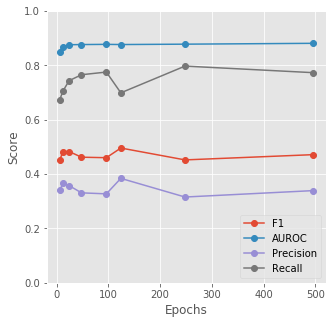

In [269]:
f, axs = plt.subplots(1,1,figsize=(5,5))

for column in df_metrics.columns:
    plt.plot(df_metrics.index,df_metrics[column],'-o',label=column)
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('Epochs')

plt.savefig('scores_per_hidden_aps.pdf')

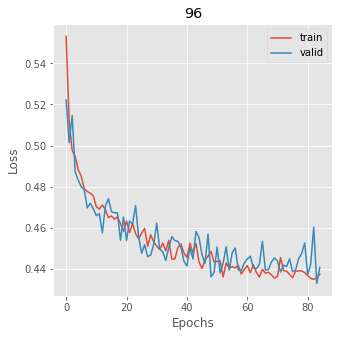

In [290]:
f, axs = plt.subplots(1,1,figsize=(5,5))
hidden_idx = 4
plt.title(hidden[hidden_idx])
plt.plot(res['conv'][hidden_idx]['train'],label='train')
plt.plot(res['conv'][hidden_idx]['valid'],label='valid')

plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.savefig('one_layer_hidden_{}_aps.pdf'.format(hidden[hidden_idx]))

In [302]:
# number of epochs to train the model
n_epochs = 200
hidden = 96
conv,model = train_per_hidden(n_epochs, hidden, OneLayerNet)   

Epoch: 1 	Training Loss: 0.552890 	Validation Loss: 0.516275
Epoch: 2 	Training Loss: 0.509763 	Validation Loss: 0.513156
Epoch: 3 	Training Loss: 0.502041 	Validation Loss: 0.492123
Epoch: 4 	Training Loss: 0.488632 	Validation Loss: 0.502360
Epoch: 5 	Training Loss: 0.489125 	Validation Loss: 0.481919
Epoch: 6 	Training Loss: 0.482087 	Validation Loss: 0.480840
Epoch: 7 	Training Loss: 0.480278 	Validation Loss: 0.473505
Epoch: 8 	Training Loss: 0.476277 	Validation Loss: 0.476836
Epoch: 9 	Training Loss: 0.477740 	Validation Loss: 0.466418
Epoch: 10 	Training Loss: 0.473730 	Validation Loss: 0.472784
Epoch: 11 	Training Loss: 0.467660 	Validation Loss: 0.472234
Epoch: 12 	Training Loss: 0.468850 	Validation Loss: 0.478543
Epoch: 13 	Training Loss: 0.467142 	Validation Loss: 0.462711
Epoch: 14 	Training Loss: 0.465839 	Validation Loss: 0.465984
Epoch: 15 	Training Loss: 0.459967 	Validation Loss: 0.458356
Epoch: 16 	Training Loss: 0.460498 	Validation Loss: 0.465242
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.430952 	Validation Loss: 0.448437
Epoch: 134 	Training Loss: 0.429246 	Validation Loss: 0.442541
Epoch: 135 	Training Loss: 0.425779 	Validation Loss: 0.437728
Epoch: 136 	Training Loss: 0.426283 	Validation Loss: 0.441275
Epoch: 137 	Training Loss: 0.425517 	Validation Loss: 0.442626
Epoch: 138 	Training Loss: 0.425357 	Validation Loss: 0.446402
Epoch: 139 	Training Loss: 0.426630 	Validation Loss: 0.457400
Epoch: 140 	Training Loss: 0.424086 	Validation Loss: 0.454567
Epoch: 141 	Training Loss: 0.424059 	Validation Loss: 0.444511
Epoch: 142 	Training Loss: 0.428025 	Validation Loss: 0.444973
Epoch: 143 	Training Loss: 0.424620 	Validation Loss: 0.444616
Epoch: 144 	Training Loss: 0.426419 	Validation Loss: 0.437797
Epoch: 145 	Training Loss: 0.426197 	Validation Loss: 0.444843
Epoch: 146 	Training Loss: 0.426812 	Validation Loss: 0.443161
Epoch: 147 	Training Loss: 0.424176 	Validation Loss: 0.448182
Epoch: 148 	Training Loss: 0.429245 	Validation Loss: 0

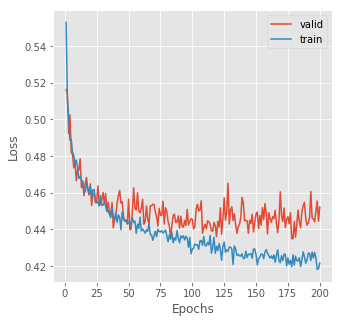

In [303]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'],label='valid')
plt.plot(epochs,conv['train'],label='train')
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.savefig('aps_one_layer.pdf')

In [304]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.48 auroc: 0.88 precision: 0.36 recall: 0.74


In [305]:
# number of epochs to train the model
n_epochs = 200
hidden = 48
conv,model = train_per_hidden(n_epochs, hidden, TwoLayersNet)   

Epoch: 1 	Training Loss: 0.549861 	Validation Loss: 0.531045
Epoch: 2 	Training Loss: 0.510084 	Validation Loss: 0.497694
Epoch: 3 	Training Loss: 0.497513 	Validation Loss: 0.487370
Epoch: 4 	Training Loss: 0.489668 	Validation Loss: 0.489179
Epoch: 5 	Training Loss: 0.486990 	Validation Loss: 0.477260
Epoch: 6 	Training Loss: 0.489033 	Validation Loss: 0.473897
Epoch: 7 	Training Loss: 0.478525 	Validation Loss: 0.470562
Epoch: 8 	Training Loss: 0.474115 	Validation Loss: 0.463981
Epoch: 9 	Training Loss: 0.476164 	Validation Loss: 0.458564
Epoch: 10 	Training Loss: 0.471122 	Validation Loss: 0.473145
Epoch: 11 	Training Loss: 0.470645 	Validation Loss: 0.469515
Epoch: 12 	Training Loss: 0.477349 	Validation Loss: 0.469608
Epoch: 13 	Training Loss: 0.473905 	Validation Loss: 0.470256
Epoch: 14 	Training Loss: 0.475559 	Validation Loss: 0.463707
Epoch: 15 	Training Loss: 0.470972 	Validation Loss: 0.466113
Epoch: 16 	Training Loss: 0.467311 	Validation Loss: 0.469577
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.439649 	Validation Loss: 0.439649
Epoch: 134 	Training Loss: 0.433473 	Validation Loss: 0.444111
Epoch: 135 	Training Loss: 0.433318 	Validation Loss: 0.443785
Epoch: 136 	Training Loss: 0.431679 	Validation Loss: 0.441694
Epoch: 137 	Training Loss: 0.429350 	Validation Loss: 0.448627
Epoch: 138 	Training Loss: 0.435132 	Validation Loss: 0.445341
Epoch: 139 	Training Loss: 0.431484 	Validation Loss: 0.444523
Epoch: 140 	Training Loss: 0.436098 	Validation Loss: 0.457759
Epoch: 141 	Training Loss: 0.437513 	Validation Loss: 0.439224
Epoch: 142 	Training Loss: 0.430041 	Validation Loss: 0.436265
Epoch: 143 	Training Loss: 0.432861 	Validation Loss: 0.449723
Epoch: 144 	Training Loss: 0.436466 	Validation Loss: 0.438061
Epoch: 145 	Training Loss: 0.435003 	Validation Loss: 0.439364
Epoch: 146 	Training Loss: 0.433440 	Validation Loss: 0.434568
Epoch: 147 	Training Loss: 0.438965 	Validation Loss: 0.452695
Epoch: 148 	Training Loss: 0.433558 	Validation Loss: 0

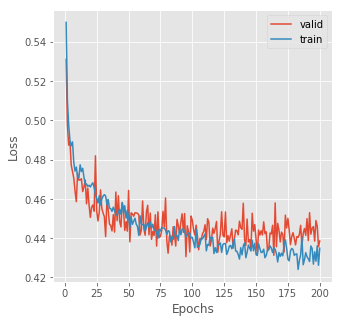

In [306]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'],label='valid')
plt.plot(epochs,conv['train'],label='train')
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.savefig('aps_two_layers.pdf')

In [307]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.49 auroc: 0.88 precision: 0.36 recall: 0.74


In [308]:
# number of epochs to train the model
n_epochs = 200
hidden = 48
conv,model = train_per_hidden(n_epochs, hidden, ThreeLayersNet)   

Epoch: 1 	Training Loss: 0.554616 	Validation Loss: 0.507489
Epoch: 2 	Training Loss: 0.513410 	Validation Loss: 0.491318
Epoch: 3 	Training Loss: 0.501135 	Validation Loss: 0.500375
Epoch: 4 	Training Loss: 0.494476 	Validation Loss: 0.475213
Epoch: 5 	Training Loss: 0.495443 	Validation Loss: 0.479534
Epoch: 6 	Training Loss: 0.489358 	Validation Loss: 0.487974
Epoch: 7 	Training Loss: 0.481340 	Validation Loss: 0.470562
Epoch: 8 	Training Loss: 0.486771 	Validation Loss: 0.467565
Epoch: 9 	Training Loss: 0.480780 	Validation Loss: 0.489677
Epoch: 10 	Training Loss: 0.477672 	Validation Loss: 0.468007
Epoch: 11 	Training Loss: 0.475435 	Validation Loss: 0.462011
Epoch: 12 	Training Loss: 0.475687 	Validation Loss: 0.468144
Epoch: 13 	Training Loss: 0.472236 	Validation Loss: 0.472765
Epoch: 14 	Training Loss: 0.467609 	Validation Loss: 0.461201
Epoch: 15 	Training Loss: 0.467442 	Validation Loss: 0.456637
Epoch: 16 	Training Loss: 0.474285 	Validation Loss: 0.463345
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.443009 	Validation Loss: 0.454046
Epoch: 134 	Training Loss: 0.436526 	Validation Loss: 0.459766
Epoch: 135 	Training Loss: 0.439509 	Validation Loss: 0.454603
Epoch: 136 	Training Loss: 0.439412 	Validation Loss: 0.460984
Epoch: 137 	Training Loss: 0.436896 	Validation Loss: 0.446621
Epoch: 138 	Training Loss: 0.440107 	Validation Loss: 0.456014
Epoch: 139 	Training Loss: 0.437857 	Validation Loss: 0.462160
Epoch: 140 	Training Loss: 0.436901 	Validation Loss: 0.451790
Epoch: 141 	Training Loss: 0.438335 	Validation Loss: 0.447256
Epoch: 142 	Training Loss: 0.439830 	Validation Loss: 0.441869
Epoch: 143 	Training Loss: 0.437492 	Validation Loss: 0.451041
Epoch: 144 	Training Loss: 0.438467 	Validation Loss: 0.441938
Epoch: 145 	Training Loss: 0.437167 	Validation Loss: 0.448132
Epoch: 146 	Training Loss: 0.440569 	Validation Loss: 0.467271
Epoch: 147 	Training Loss: 0.434419 	Validation Loss: 0.458004
Epoch: 148 	Training Loss: 0.440261 	Validation Loss: 0

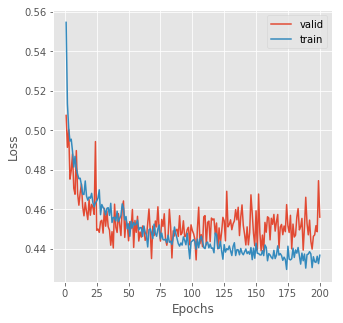

In [309]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'],label='valid')
plt.plot(epochs,conv['train'],label='train')
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.savefig('aps_three_layers.pdf')

In [310]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.47 auroc: 0.88 precision: 0.34 recall: 0.75


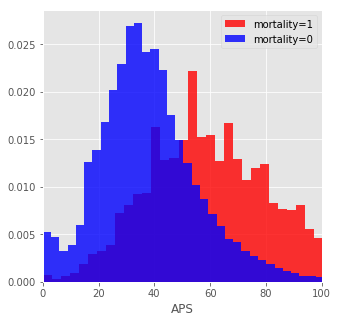

In [222]:
f, axs = plt.subplots(1,1,figsize=(5,5))

axs.hist(aps_ad_2.loc[aps_ad_2.hospital_expire_flag == 1].apsiii,density=1,color='red',label='mortality=1',bins=57,alpha=0.8)
axs.hist(aps_ad_2.loc[aps_ad_2.hospital_expire_flag == 0].apsiii,density=1,color='blue',label='mortality=0',bins=63,alpha=0.8)
axs.legend(loc='best')
axs.set_xlim(0,100)
axs.set_xlabel('APS')

plt.savefig('APS.pdf')

In [219]:
# Load in the query from file
query='SELECT * FROM OASIS'
oasis = pd.read_sql_query(query, connect)
oasis = oasis.dropna(axis=0)
oasis = oasis.loc[(oasis.urineoutput < 20000) & (oasis.urineoutput > 0) & 
                  (oasis.temp > 30) & (oasis.temp < 45) & (oasis.icustay_age_group == 'adult')]
oasis['preiculos_hours'] = oasis.preiculos.dt.total_seconds()/3600

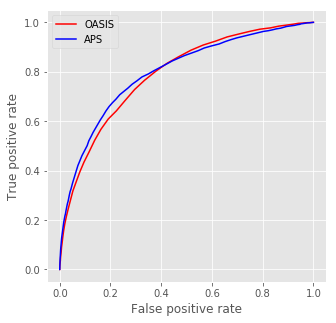

In [225]:
f, axs = plt.subplots(1,1,figsize=(5,5))

a,b,c = roc_curve(oasis.hospital_expire_flag, oasis.oasis_prob)
axs.plot(a,b,label='OASIS',color='red')
a,b,c = roc_curve(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob)
axs.plot(a,b,label='APS',color='blue')
axs.legend(loc='best')
axs.set_xlabel('False positive rate')
axs.set_ylabel('True positive rate')
plt.savefig('roc_oasis_aps.pdf')

In [230]:
F1 = f1_score(oasis.hospital_expire_flag, oasis.oasis_prob.round())
auroc = roc_auc_score(oasis.hospital_expire_flag, oasis.oasis_prob)
precision = precision_score(oasis.hospital_expire_flag, oasis.oasis_prob.round())
recall = recall_score(oasis.hospital_expire_flag, oasis.oasis_prob.round())
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.28 auroc: 0.79 precision: 0.55 recall: 0.18


In [231]:
F1 = f1_score(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob.round())
auroc = roc_auc_score(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob)
precision = precision_score(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob.round())
recall = recall_score(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob.round())
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.23 auroc: 0.80 precision: 0.65 recall: 0.14
